In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the dataset
data = pd.read_csv('stores_sales_forecasting.csv', encoding='iso-8859-1')

# Inspect the data
print(data.head())
print(data.info())
print(data.describe())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region       Product ID

In [4]:
# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows/columns
data = data.dropna()  # Example: drop rows with missing values


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [5]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


In [6]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [7]:
#Split Data into Training and Testing Sets
X = data.drop('Sales', axis=1)
y = data['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize XGBRegressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, reg_lambda=0.001, n_estimators=300, learning_rate=0.8)

# Train the model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.8, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')


MSE: 0.5103032622332656
MAE: 0.3278159724266842
R2 Score: 0.5785447612115115


In [10]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')


Cross-Validation MSE: 0.44735576804826505


In [11]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Re-train with best parameters
best_model = grid_search.best_estimator_



Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [13]:
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model R^2 Score: {r2_best}')


Best Model Mean Squared Error: 0.2606460692348159
Best Model R^2 Score: 0.7847345696598227


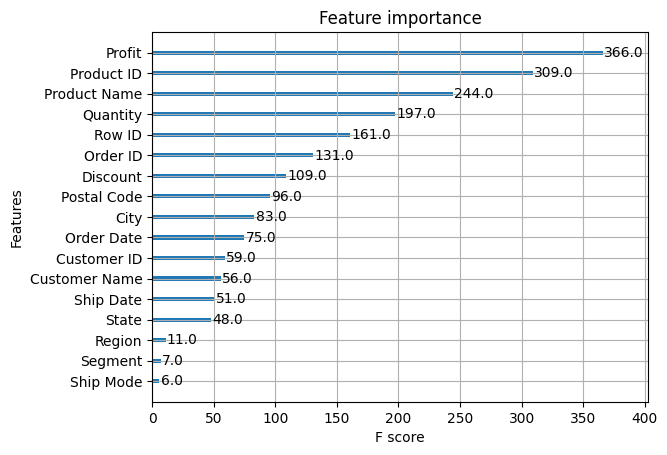

In [14]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.show()


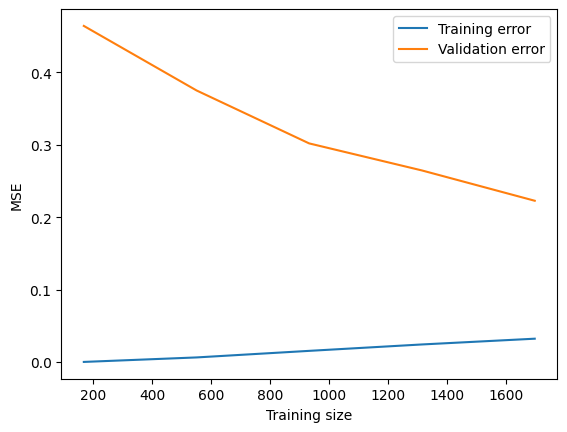

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.ylabel('MSE')
plt.xlabel('Training size')
plt.legend()
plt.show()


c:\Users\Kgwanti Bilankulu\Documents\NexData Solutions\Demo Projects\Sales Forecasting\salesvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


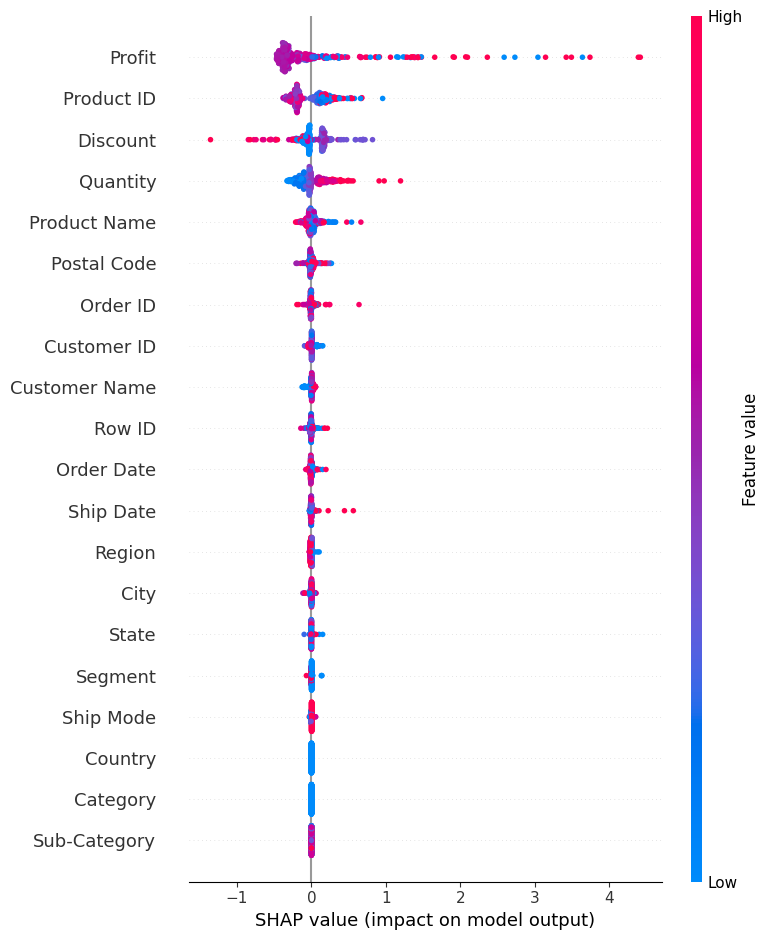

In [17]:

import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test)



In [18]:
from skopt import BayesSearchCV
from xgboost import XGBRegressor

# Define the hyperparameter space
param_space = {
    'n_estimators': (50, 200,300,400),
    'learning_rate': (0.01, 0.1,  0.2),
    'max_depth': (3, 5, 7)
}


In [19]:
# Initialize the model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up Bayesian optimization
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=32,  # Number of iterations
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)


In [20]:
# Fit the optimizer
opt.fit(X_train, y_train)

# Get the best parameters
best_params = opt.best_params_
print(f'Best Parameters: {best_params}')

# Train the model with the best parameters
best_model = opt.best_estimator_

# Predict and evaluate
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best MSE: {mse_best}, Best MAE: {mae_best}, Best R²: {r2_best}')



c:\Users\Kgwanti Bilankulu\Documents\NexData Solutions\Demo Projects\Sales Forecasting\salesvenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 300] before, using random point [0.2, 3, 400]
  warnings.warn(
c:\Users\Kgwanti Bilankulu\Documents\NexData Solutions\Demo Projects\Sales Forecasting\salesvenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2, 3, 400] before, using random point [0.2, 3, 300]
  warnings.warn(


Best Parameters: OrderedDict({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400})
Best MSE: 0.2385746520166703, Best MAE: 0.23488066775394406, Best R²: 0.8029631703812146
